# Example 8: Piecewise Polynomial Models and Cubic Splines

**Piecewise polynomials** are models involving segments of polynomials joined together to fit data. These models are especially useful when the relationship between the independent and dependent variable is complex and non-linear. We construct these models by dividing the data range into segments. A polynomial is then fit to the data within each segment.

These models can fit a wide variety of shapes and are very flexible, making them suitable for modeling complex datasets. One challenge, however, is ensuring smoothness and continuity at the points where the polynomial segments meet. This is where cubic splines come into play.

## Cubic Splines

**Cubic splines** are a specific type of piecewise polynomial model where each segment is a third-degree polynomial (a cubic polynomial). They are constructed in such a way that so that continuity is achieved at the segment boundaries, also called **knots**. In addition, the cubic segments have matching first and second derivatives along these knots, which ensures smoothness.

In [1]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt

# For model and evaluation
from scipy.interpolate import CubicSpline
from scipy.interpolate import LSQUnivariateSpline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

## Small, Precise Datasets

In general, polynomial models are an excellent tool in many situations, including ones where our dataset is small and our datapoints are very precise (little noise). Let's suppose the dataset below is one such dataset. 

In [18]:
# Generate some sample data points
x = np.array([1, 2, 3, 4, 5, 6])
y = np.array([1, 3, 2, 4, 1, 2])

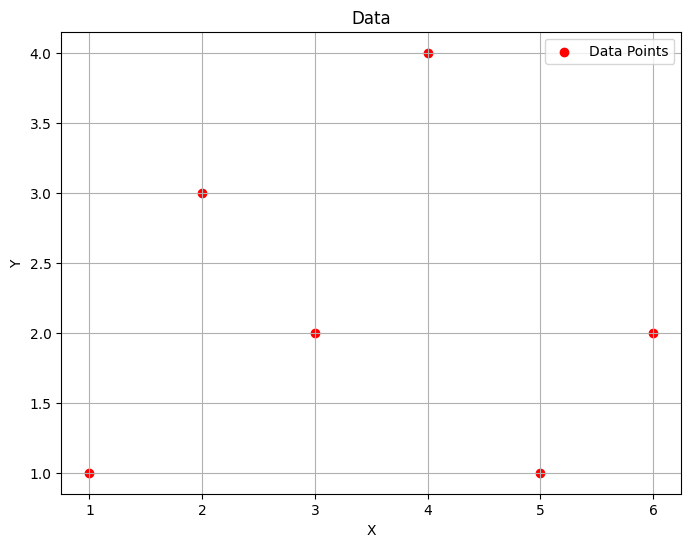

In [19]:
# Plot the  data points 
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Data')
plt.grid(True)
plt.show()

A näive way we could construct a model for these points is piecewise linear, meaning we just connect the points with straight lines. This is not a terrible model, but there is no reason to believe it to be a good approximation. In fact, such a model has the highest possible variance (with respect to the bias-variance tradeoff) because it only responds to the data. 

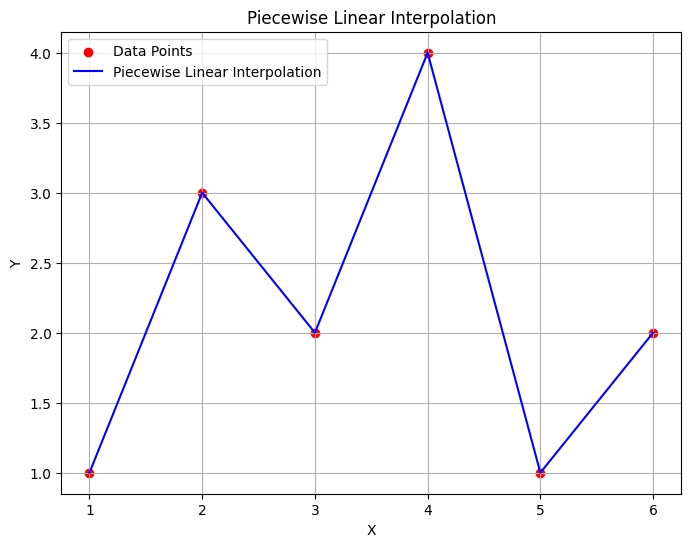

In [20]:
# Construct a piecewise linear model to the data
# Define the breakpoints (where the segments change)
breakpoints = [2, 4]

# Initialize lists to store interpolated values
x_interp = []
y_interp = []

# Perform piecewise linear interpolation
for i in range(len(breakpoints) + 1):
    if i == 0:
        # First segment
        mask = (x <= breakpoints[i])
    elif i == len(breakpoints):
        # Last segment
        mask = (x > breakpoints[i - 1])
    else:
        # Middle segments
        mask = (x > breakpoints[i - 1]) & (x <= breakpoints[i])
    
    x_segment = x[mask]
    y_segment = y[mask]
    
    if len(x_segment) > 1:
        # Fit a linear model (y = mx + b) to each segment
        m, b = np.polyfit(x_segment, y_segment, deg=1)
        
        # Generate interpolated points within the segment
        x_interp_segment = np.linspace(min(x_segment), max(x_segment), num=100)
        y_interp_segment = m * x_interp_segment + b
        
        # Append the segment to the overall interpolated result
        x_interp.extend(x_interp_segment)
        y_interp.extend(y_interp_segment)

# Plot the original data and the piecewise linear interpolation
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points', color='red')
plt.plot(x_interp, y_interp, label='Piecewise Linear Interpolation', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Piecewise Linear Interpolation')
plt.grid(True)
plt.show()

Polynomials are on way we can treat the points as precise and construct a smoothed out function with less variance (although it is still a high variance model). 

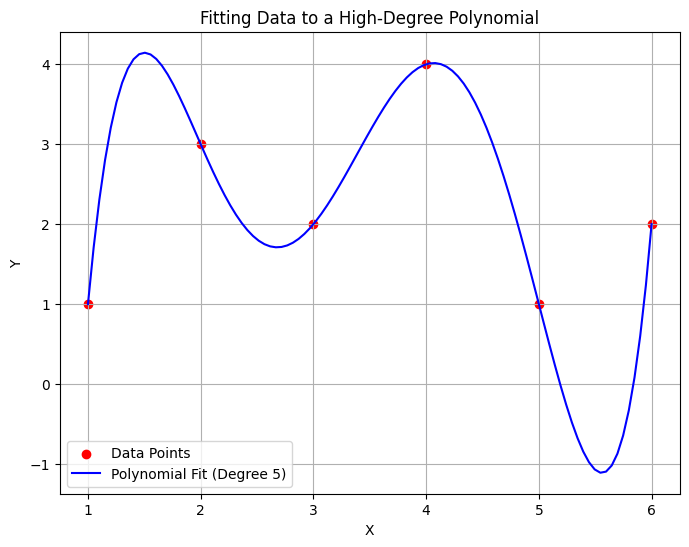

In [21]:
# Fit a high-degree polynomial (e.g., degree 5) to the data
degree = 5
coefficients = np.polyfit(x, y, degree)

# Create a polynomial function based on the coefficients
poly_function = np.poly1d(coefficients)

# Generate points for the fitted polynomial curve
x_fit = np.linspace(min(x), max(x), 100)
y_fit = poly_function(x_fit)

# Plot the original data and the fitted polynomial curve
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points', color='red')
plt.plot(x_fit, y_fit, label=f'Polynomial Fit (Degree {degree})', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Fitting Data to a High-Degree Polynomial')
plt.grid(True)
plt.show()

A downside of this approach is that the model is incredibly steep at the end points which makes the model more variable at those points and casts doubt on their accuracy. An alternative is the cubic spline. These are polynomial segments specifically designs to have tamer endpoints. Lets consider a natural cubic spline, which treats all of the points as knots. 

In [22]:
# Create a natural cubic spline interpolation
spline = CubicSpline(x, y, bc_type='natural')

# Generate points for the interpolated curve
x_interp = np.linspace(1, 6, 100)
y_interp = spline(x_interp)

Notice that the model does not have wild derivatives around the points, especially the ends. That's by design. 

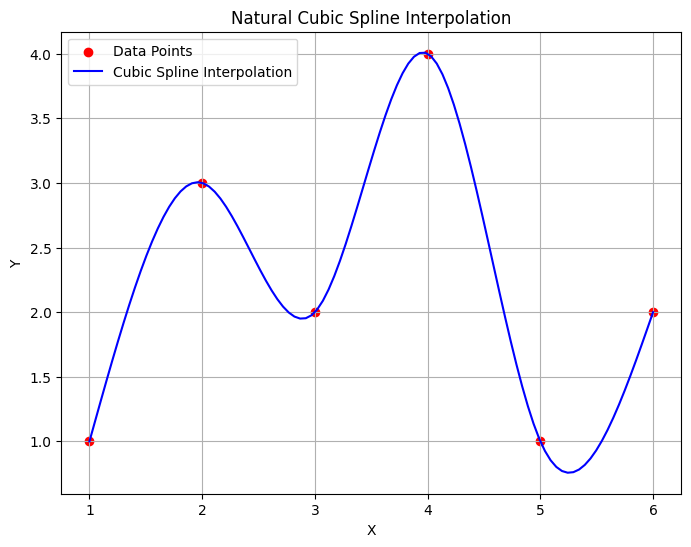

In [24]:
# Plot the original data points and the interpolated curve
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data Points', color='red')
plt.plot(x_interp, y_interp, label='Cubic Spline Interpolation', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Natural Cubic Spline Interpolation')
plt.grid(True)
plt.show()

## Larger Datasets

Here we define a dataset whose ground truth is $$Y = \sin^2(X) + \epsilon.$$ Although the model has noise, we designed the data to have little noise relative to the actual relationship. 

In [27]:
# Define the data points and intervals
X = np.linspace(0, 6, 500)  # 500 points spanning [0, 6]
Y = np.sin(X)**2 + np.random.normal(0, 0.025, 500)  # Generate noisy data

# Split the data into training, validation, and testing sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, 
                                                    random_state=8)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, 
                                                random_state=8)

# For fitting the function once hyperparameters are selected
X_train_val = np.concatenate((X_train, X_val))
Y_train_val = np.concatenate((Y_train, Y_val))

# Sort to ensure strictly increasing x values
sorted_indices = np.argsort(X_train)
X_train = X_train[sorted_indices]
Y_train = Y_train[sorted_indices]

sorted_indices = np.argsort(X_val)
X_val = X_val[sorted_indices]
Y_val = Y_val[sorted_indices]

sorted_indices = np.argsort(X_train_val)
X_train_val = X_train_val[sorted_indices]
Y_train_val = Y_train_val[sorted_indices]

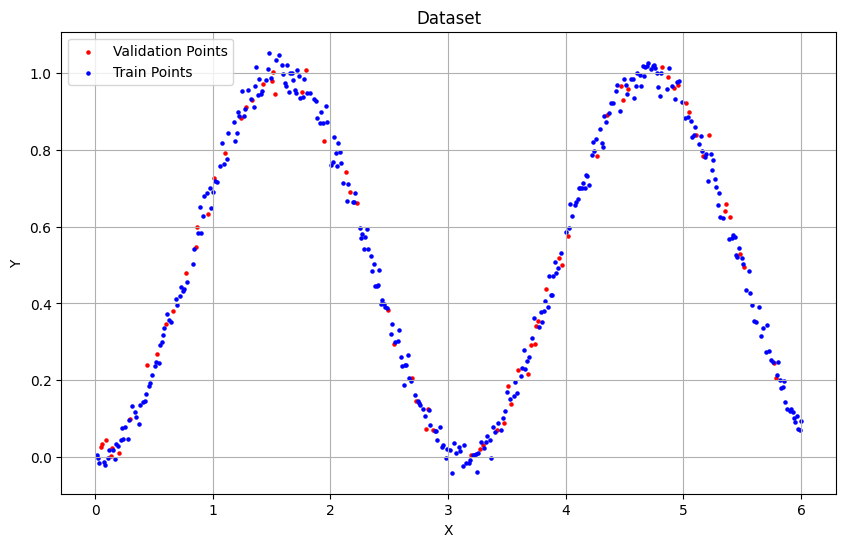

In [28]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(X_val, Y_val, label='Validation Points', color='red', s=5)
plt.scatter(X_train, Y_train, label='Train Points', color='blue', s=5)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Dataset')
plt.grid(True)
plt.show()

Cubic splines involve defining intervals, or knots. The location of these knots and their quantity are our *hyperparameters*. Based on their location, we will get different outcomes for our model. 

In [29]:
# Define internal knots for the cubic spline
knots = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 5]  

# Fit the cubic spline model
model = LSQUnivariateSpline(X_train, Y_train, t=knots)

# Now, you can use `model` to predict values or evaluate the model
# For example, to predict at new points:
Y_pred = model(X_val)

We can evaluate our model's efficancy by looking at the mean squared error and the $R^2$. As you play around with the location and number of knots, you'll see these values can change dramatically. The smoothness restriction has a big impact on the shape of the cubic spline.  

In [30]:
# Calculate metrics on the testing set
mse = mean_squared_error(Y_pred, Y_val)
r2 = r2_score(Y_pred, Y_val)

# Display metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 0.0008
R-squared (R2): 0.9936


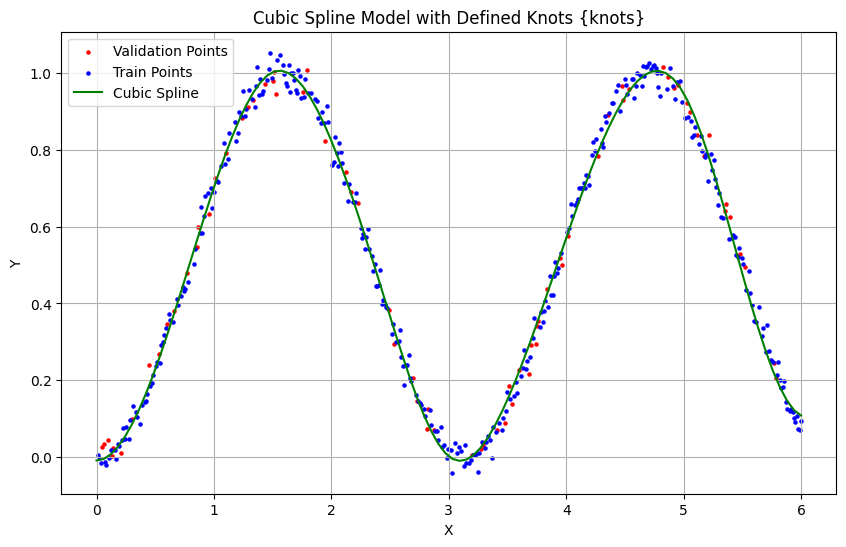

In [31]:
X_new = np.linspace(0, 6, 100)
Y_pred_new = model(X_new)

# Plot the original data and the cubic spline interpolation
plt.figure(figsize=(10, 6))
plt.scatter(X_val, Y_val, label='Validation Points', color='red', s=5)
plt.scatter(X_train, Y_train, label='Train Points', color='blue', s=5)
plt.plot(X_new, Y_pred_new, label='Cubic Spline', color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Cubic Spline Model with Defined Knots {knots}')
plt.grid(True)
plt.show()



In practice, we would set up a search space for our knots and select the set of knots that best suits our model. Let's suppose we settle on the knots $[1, 2, 3, 4, 5]$. We could then evaluate our model using the testing set. 

In [32]:
# Define internal knots for the cubic spline
knots = [1, 2, 3, 4, 5]  

# Fit the cubic spline model
model = LSQUnivariateSpline(X_train_val, Y_train_val, t=knots)

# Now, you can use `model` to predict values or evaluate the model
# For example, to predict at new points:
Y_pred = model(X_test)

In [33]:
# Calculate metrics on the testing set
mse = mean_squared_error(Y_pred, Y_test)
r2 = r2_score(Y_pred, Y_test)

# Display metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 0.0008
R-squared (R2): 0.9934


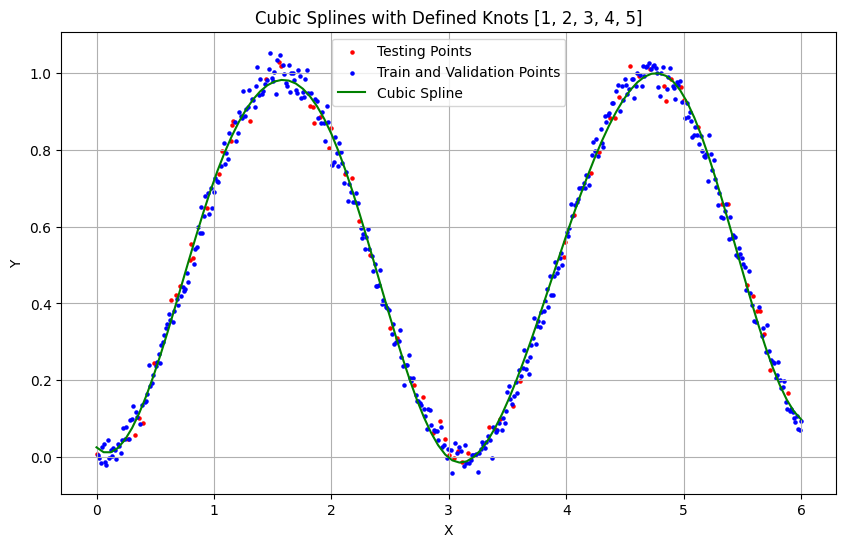

In [34]:
X_new = np.linspace(0, 6, 100)
Y_pred_new = model(X_new)

# Plot the original data and the cubic spline interpolation
plt.figure(figsize=(10, 6))
plt.scatter(X_test, Y_test, label='Testing Points', color='red', s=5)
plt.scatter(X_train_val, Y_train_val, label='Train and Validation Points', color='blue', s=5)
plt.plot(X_new, Y_pred_new, label='Cubic Spline', color='green')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title(f'Cubic Splines with Defined Knots {knots}')
plt.grid(True)
plt.show()

With regression functions, it is good practice to plot the residuals to ensure a good fit. If we see a pattern in how the residuals are displayed, that suggests the model is a poor fit for the data (even if the metrics look good). 

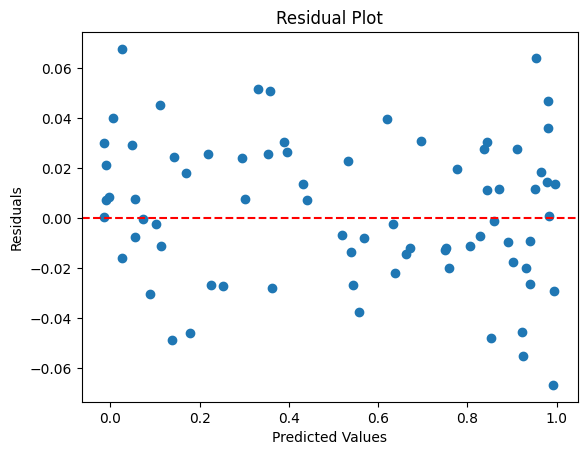

In [35]:
residuals = Y_test - Y_pred

# Plotting the residuals
plt.scatter(Y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Show the plot
plt.show()

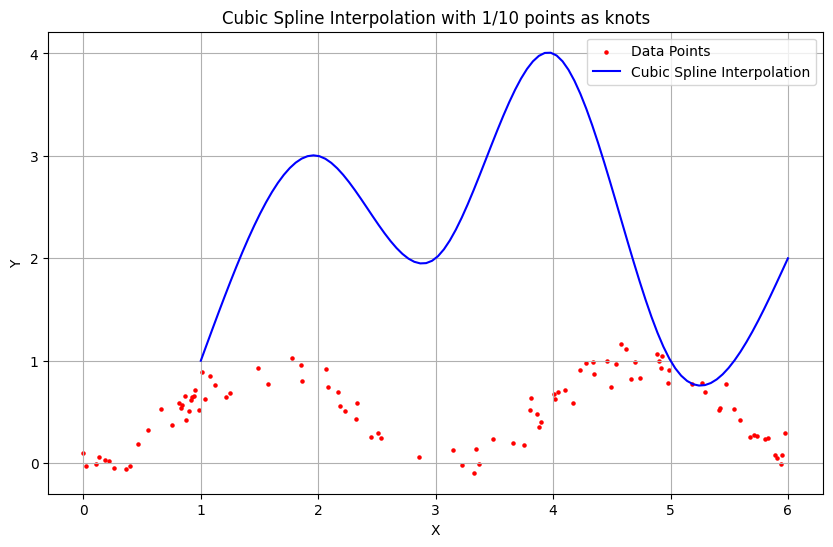

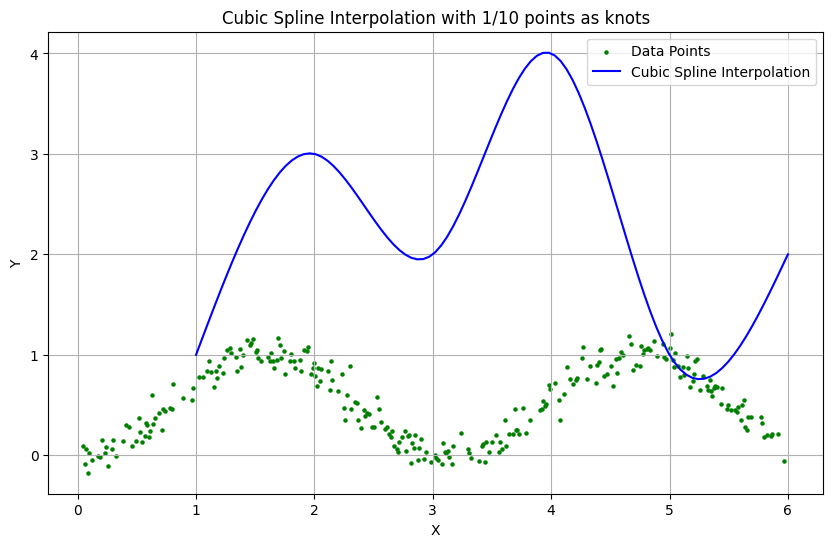

Mean Squared Error (MSE): 0.5046
R-squared (R2): -3.4854


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split

# Define the data points and intervals
X = np.linspace(0, 6, 500)  # 500 points spanning [0, 6]
y = np.sin(X)**2 + np.random.normal(0, 0.1, 500)  # Generate noisy data

# Split the data into training and test sets (e.g., 80% train, 20% test)
# Testing is used to evaluate the selected model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data further into training and validation sets (e.g., 70% train, 30% validation)
# Validation is used to determine lambda (or any hyperparameter)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Sort X_train and y_train to ensure strictly increasing x values
sorted_indices = np.argsort(X_train)
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]

# 1/10 points are treated as knots
spline = CubicSpline(x_segment, y_segment)
y_test_pred = spline(X_test)

# Plot the original data and the cubic spline interpolation
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, label='Data Points', color='red', s=5)
plt.plot(x_interp, y_interp, label='Cubic Spline Interpolation', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Cubic Spline Interpolation with 1/10 points as knots')
plt.grid(True)
plt.show()

# Plot the original data and the cubic spline interpolation
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label='Data Points', color='green', s=5)
plt.plot(x_interp, y_interp, label='Cubic Spline Interpolation', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Cubic Spline Interpolation with 1/10 points as knots')
plt.grid(True)
plt.show()

# Calculate metrics on the testing set
y_test_pred = CubicSpline(X_train, y_train, bc_type='natural')(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Display metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

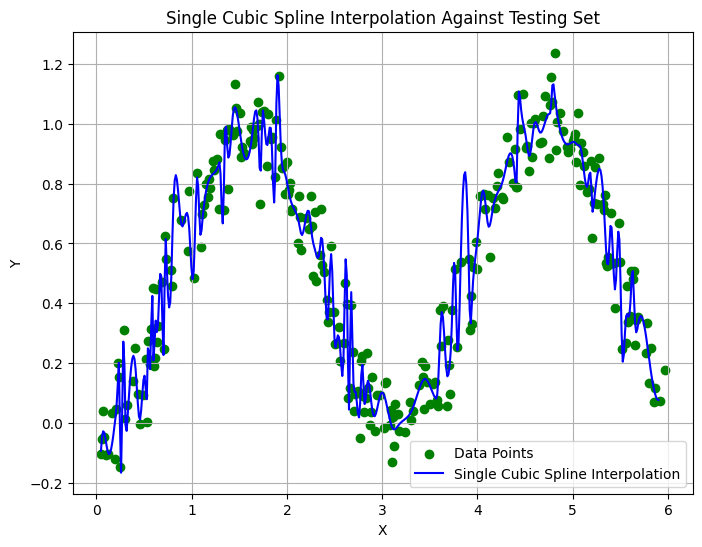

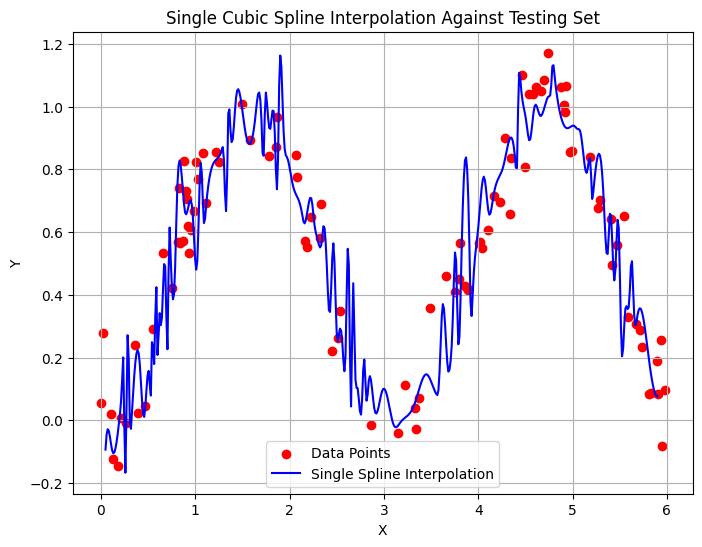

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import train_test_split

# Define the data points and intervals
X = np.linspace(0, 6, 500)  # 500 points spanning [0, 6]
y = np.sin(X)**2 + np.random.normal(0, 0.1, 500)  # Generate noisy data

# Split the data into training and test sets (e.g., 80% train, 20% test)
# Testing is used to evaluate the selected model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the training data further into training and validation sets (e.g., 70% train, 30% validation)
# Validation is used to determine lambda (or any hyperparameter)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# Sort X_train and y_train to ensure strictly increasing x values
sorted_indices = np.argsort(X_train)
X_train = X_train[sorted_indices]
y_train = y_train[sorted_indices]

# Create a natural cubic spline interpolation
spline = UnivariateSpline(X_train, y_train, s=1)

# Generate points for the interpolated curve
x_interp = np.linspace(X_train[0], 5.9, 500)
y_interp = spline(x_interp)

# Plot the training data points and the interpolated curve
plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, label='Data Points', color='green')
plt.plot(x_interp, y_interp, label='Single Cubic Spline Interpolation', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Single Cubic Spline Interpolation Against Testing Set')
plt.grid(True)
plt.show()

# Plot the test data points and the interpolated curve
plt.figure(figsize=(8, 6))
plt.scatter(X_test, y_test, label='Data Points', color='red')
plt.plot(x_interp, y_interp, label='Single Spline Interpolation', color='blue')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Single Cubic Spline Interpolation Against Testing Set')
plt.grid(True)
plt.show()



In [38]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate metrics on the testing set
y_test_pred = spline(X_test)
mse = mean_squared_error(y_test, y_test_pred)
r2 = r2_score(y_test, y_test_pred)

# Display metrics
print(f"Mean Squared Error (MSE) against testing: {mse:.4f}")
print(f"R-squared (R2) against testing: {r2:.4f}")

Mean Squared Error (MSE) against testing: 0.0298
R-squared (R2) against testing: 0.7440


In [39]:
# Calculate metrics on the testing set
y_train_pred = spline(X_train)
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)

# Display metrics
print(f"Mean Squared Error (MSE) against testing: {mse:.4f}")
print(f"R-squared (R2) against testing: {r2:.4f}")

Mean Squared Error (MSE) against testing: 0.0036
R-squared (R2) against testing: 0.9725
